# Vertebral Bone Density & Age Estimation Analysis (Full Dataset)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, f_oneway
from io import StringIO


In [24]:
# load dataset here


df_male = pd.read_csv("male.csv")
df_female = pd.read_csv("female.csv")
print(f"male N: {len(df_male)} female N: {len(df_female)}")

male N: 428 female N: 410


In [25]:
def describe_data(df):
    return {
        'Mean Age': df['age'].mean(),
        'Std Age': df['age'].std(),
        'Median Age': df['age'].median(),
        'IQR Age': df['age'].quantile(0.75) - df['age'].quantile(0.25),
        'Min Age': df['age'].min(),
        'Max Age': df['age'].max()
    }

describe_data(df_male), describe_data(df_female)

({'Mean Age': np.float64(49.7196261682243),
  'Std Age': np.float64(17.827849377955285),
  'Median Age': np.float64(48.0),
  'IQR Age': np.float64(28.0),
  'Min Age': np.int64(20),
  'Max Age': np.int64(95)},
 {'Mean Age': np.float64(53.1219512195122),
  'Std Age': np.float64(18.189837193128724),
  'Median Age': np.float64(52.0),
  'IQR Age': np.float64(28.75),
  'Min Age': np.int64(20),
  'Max Age': np.int64(97)})

In [26]:
r_male, p_male = pearsonr(df_male['age'], df_male['density'])
r_female, p_female = pearsonr(df_female['age'], df_female['density'])

(f"Male: r = {r_male:.2f}, p = {p_male:.3f}", f"Female: r = {r_female:.2f}, p = {p_female:.3f}")

('Male: r = -0.75, p = 0.000', 'Female: r = -0.85, p = 0.000')

In [27]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names, title=""):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(6, 4))
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=45)
    plt.title(f"Feature Importance - {title}")
    plt.tight_layout()
    plt.show()

def add_engineered_features(df):
    df = df.copy()
    df['density_squared'] = df['density'] ** 2
    df['log_density'] = np.log1p(df['density'])  # log(1 + x)
    df['inverse_density'] = 1 / (df['density'] + 1e-5)
    df['zscore_density'] = (df['density'] - df['density'].mean()) / df['density'].std()
    df['density_rank'] = df['density'].rank(pct=True)
    return df

def train_xgboost_model(df, label=""):
    df = add_engineered_features(df)

    feature_cols = ['density', 'density_squared', 'log_density', 'inverse_density', 'zscore_density', 'density_rank']
    X = df[feature_cols].values
    y = df['age'].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    model = XGBRegressor(
        n_estimators=70,
        learning_rate=0.08,
        max_depth=4,
        random_state=42,
        objective='reg:squarederror'
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"🟩 XGBoost - {label}")
    print(f"Test MAE  : {mae:.2f}")
    print(f"Test RMSE : {rmse:.2f}")
    print(f"Test R²   : {r2:.2f}\n")

    return model, scaler


feature_names = ['density', 'density_squared', 'log_density', 'inverse_density', 'zscore_density', 'density_rank']
model_female, scaler_female = train_xgboost_model(df_female, "Kadın")

model_male, scaler_male = train_xgboost_model(df_male, "Erkek")





🟩 XGBoost - Kadın
Test MAE  : 8.14
Test RMSE : 10.12
Test R²   : 0.70

🟩 XGBoost - Erkek
Test MAE  : 9.74
Test RMSE : 11.91
Test R²   : 0.58



In [28]:
from scipy.stats import iqr

def summarize_age(df):
    n = df['age'].count() 
    mean_age = df['age'].mean()
    std_age = df['age'].std()
    median_age = df['age'].median()
    q1 = df['age'].quantile(0.25)
    q3 = df['age'].quantile(0.75)
    min_age = df['age'].min()
    max_age = df['age'].max()

    return {
        'N': n,
        'Mean Age (±SD)': f"{mean_age:.1f} ± {std_age:.1f}",
        'Median Age (IQR)': f"{median_age:.0f} ({int(q1)}–{int(q3)})",
        'Min–Max Age': f"{int(min_age)}–{int(max_age)}"
    }


summary_male = summarize_age(df_male)
summary_female = summarize_age(df_female)


summary_df = pd.DataFrame([summary_male, summary_female], index=['Male', 'Female'])


import matplotlib.pyplot as plt
import pandas.plotting as pd_plotting
from IPython.display import display

display(summary_df)


,N,Mean Age (±SD),Median Age (IQR),Min–Max Age
Male,428,49.7 ± 17.8,48 (36–64),20–95
Female,410,53.1 ± 18.2,52 (39–67),20–97


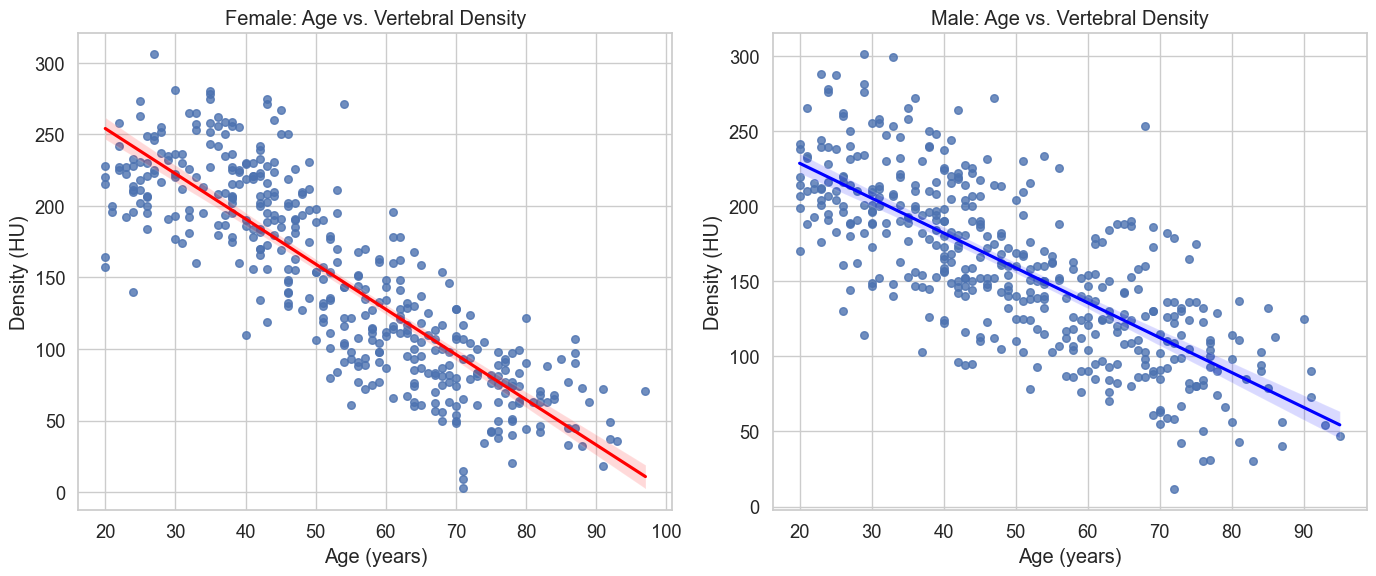

In [29]:

# Correlation plots to visualize the relationship between age and bone density.
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(14, 6))

# Female
plt.subplot(1, 2, 1)
sns.regplot(x="age", y="density", data=df_female, scatter_kws={"s": 30}, line_kws={"color": "red"})
plt.title("Female: Age vs. Vertebral Density")
plt.xlabel("Age (years)")
plt.ylabel("Density (HU)")

# Male
plt.subplot(1, 2, 2)
sns.regplot(x="age", y="density", data=df_male, scatter_kws={"s": 30}, line_kws={"color": "blue"})
plt.title("Male: Age vs. Vertebral Density")
plt.xlabel("Age (years)")
plt.ylabel("Density (HU)")

plt.tight_layout()
plt.savefig("correlation.png", dpi=300)
plt.show()


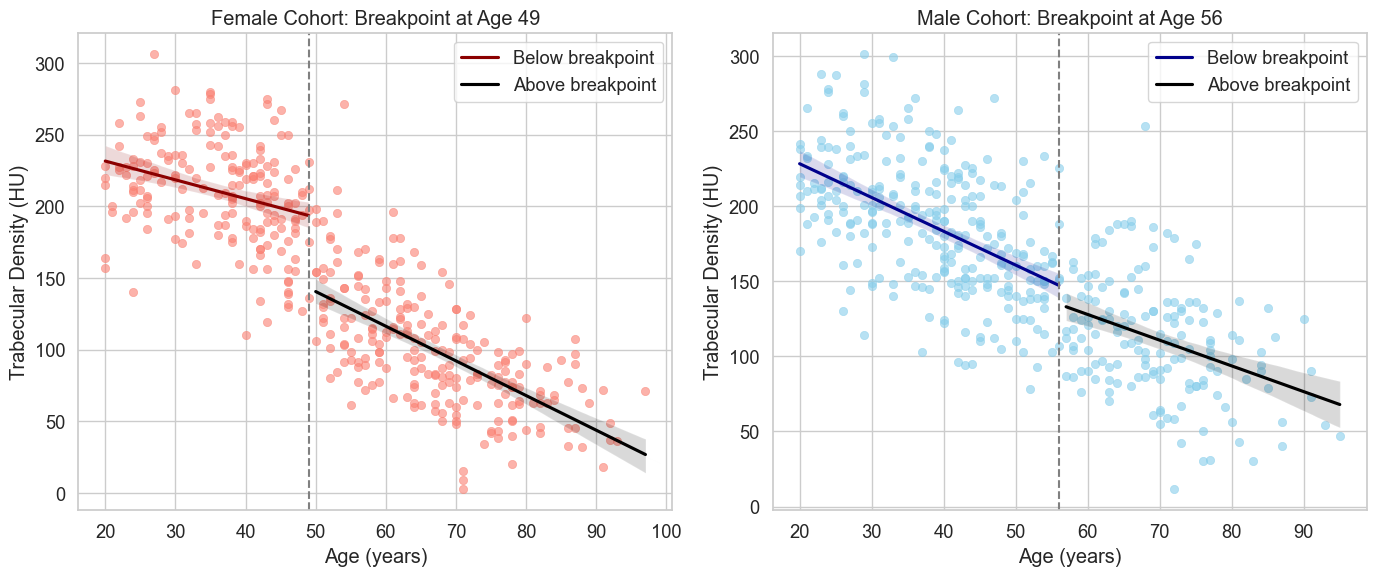

In [30]:

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Breakpoint function working over age
def find_breakpoint(df, min_age=30, max_age=80):
    ages = range(min_age, max_age + 1)
    errors = []

    for breakpoint in ages:
        df_low = df[df["age"] <= breakpoint]
        df_high = df[df["age"] > breakpoint]

        if len(df_low) < 10 or len(df_high) < 10:
            errors.append(float('inf'))
            continue

        X_low = sm.add_constant(df_low["age"])
        X_high = sm.add_constant(df_high["age"])
        y_low = df_low["density"]
        y_high = df_high["density"]

        model_low = sm.OLS(y_low, X_low).fit()
        model_high = sm.OLS(y_high, X_high).fit()

        error = model_low.ssr + model_high.ssr
        errors.append(error)

    best_index = int(errors.index(min(errors)))
    best_age = ages[best_index]
    return best_age, errors[best_index]

# Breakpoints for both cohorts
best_female_age, _ = find_breakpoint(df_female)
best_male_age, _ = find_breakpoint(df_male)

# Create scatter plots with regression lines
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(14, 6))

# Female
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_female, x="age", y="density", alpha=0.6, color="salmon", edgecolor=None)
sns.regplot(data=df_female[df_female["age"] <= best_female_age], x="age", y="density", scatter=False, color="darkred", label="Below breakpoint")
sns.regplot(data=df_female[df_female["age"] > best_female_age], x="age", y="density", scatter=False, color="black", label="Above breakpoint")
plt.axvline(x=best_female_age, color="gray", linestyle="--")
plt.title(f"Female Cohort: Breakpoint at Age {best_female_age}")
plt.xlabel("Age (years)")
plt.ylabel("Trabecular Density (HU)")
plt.legend()

# Male
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_male, x="age", y="density", alpha=0.6, color="skyblue", edgecolor=None)
sns.regplot(data=df_male[df_male["age"] <= best_male_age], x="age", y="density", scatter=False, color="darkblue", label="Below breakpoint")
sns.regplot(data=df_male[df_male["age"] > best_male_age], x="age", y="density", scatter=False, color="black", label="Above breakpoint")
plt.axvline(x=best_male_age, color="gray", linestyle="--")
plt.title(f"Male Cohort: Breakpoint at Age {best_male_age}")
plt.xlabel("Age (years)")
plt.ylabel("Trabecular Density (HU)")
plt.legend()

plt.tight_layout()
plt.savefig("breakpoints_graph.png", dpi=300)
plt.show()


In [32]:
# logistik regression model for classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Male breakpoint: 56 years for our dataset
df_male['label'] = df_male['age'].apply(lambda x: 1 if x >= 56 else 0)
X_male = df_male[['density']]
y_male = df_male['label']
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_male, y_male, test_size=0.3, random_state=42)
model_male = LogisticRegression()
model_male.fit(X_train_m, y_train_m)
y_pred_m = model_male.predict(X_test_m)
print("Male Classification Report:")
print(classification_report(y_test_m, y_pred_m))
print("Accuracy (Male):", accuracy_score(y_test_m, y_pred_m))

# Female breakpoint: 49 years for our dataset
df_female['label'] = df_female['age'].apply(lambda x: 1 if x >= 49 else 0)
X_female = df_female[['density']]
y_female = df_female['label']
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_female, y_female, test_size=0.3, random_state=42)
model_female = LogisticRegression()
model_female.fit(X_train_f, y_train_f)
y_pred_f = model_female.predict(X_test_f)
print("Female Classification Report:")
print(classification_report(y_test_f, y_pred_f))
print("Accuracy (Female):", accuracy_score(y_test_f, y_pred_f))


Male Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        85
           1       0.79      0.61      0.69        44

    accuracy                           0.81       129
   macro avg       0.81      0.77      0.78       129
weighted avg       0.81      0.81      0.81       129

Accuracy (Male): 0.813953488372093
Female Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        43
           1       0.95      0.93      0.94        80

    accuracy                           0.92       123
   macro avg       0.91      0.92      0.91       123
weighted avg       0.92      0.92      0.92       123

Accuracy (Female): 0.9186991869918699
